In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True


In [2]:
import torch
from torch import nn
from torch.utils.data import random_split, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer

from src.dataset_handling import TextDataset, TextClassificationDataset
from src.utils import get_hidden_activations, activation_label_generator
from src.sparse_autoencoders import SAE_topk
import tqdm.auto as tqdm

import json
import pandas as pd
import os
from matplotlib import pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# For the base model
url = "EleutherAI/pythia-14m"
hookpoints = ["gpt_neox.layers.3.mlp.act"]
out_folder = f"models/sparse_autoencoders/{url.split('/')[-1]}"
log_folder = f"training_logs/sparse_autoencoders/{url.split('/')[-1]}"

model = AutoModelForCausalLM.from_pretrained(url).to(device)
tokenizer = AutoTokenizer.from_pretrained(url)
batch_size = 32
learning_rate = 1e-3

data_path = 'data/split/tedtalks_train.tsv'
data = TextClassificationDataset.from_tsv(data_path)

dataloader = DataLoader(
    dataset=data,
    batch_size=batch_size,
    shuffle=True
)

In [4]:
# SAE data

input_size = model.config.intermediate_size

expansion_factor = 4

meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': int(math.sqrt(input_size*expansion_factor))
}

sae = SAE_topk(meta_data=meta_data).to(device)

In [5]:
class SaeTrainer():
    def __init__(self, meta_data, learning_rate, hookpoint, device):
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.hookpoint = hookpoint

        self.model = SAE_topk(meta_data).to(device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        self.batches = 0

        self.losses = []


    def train_step(self, input_, labels):
        outputs = self.model(input_).to(device)
        loss = self.loss_fn(outputs, labels)
        hiddens = self.model.hidden_activations
        active_neurons = len(torch.unique(hiddens.indices))
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        self.losses.append((loss.item(), active_neurons))
        self.batches += 1
        return loss, active_neurons

    def plot_loss(self, out_file = None):
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        losses, active_neurons = zip(*self.losses)
        ax.plot(losses, label='Loss')
        ax2 = ax.twinx()
        ax2.plot(active_neurons, label='Active neurons', color='orange')
        ax.set_xlabel('batch nr')
        ax.set_ylabel('loss')
        ax2.set_ylabel(f'active neurons per batch (batch_size: {batch_size})')
        ax.set_title(self.hookpoint)
        fig.legend()

        if out_file:
            fig.savefig(out_file, dpi=300)
        else:
            plt.show()

In [6]:
sae_trainers = [
    SaeTrainer(meta_data, learning_rate, hookpoint, device)
    for hookpoint in hookpoints
]

In [7]:
for activations, _ in activation_label_generator(dataloader, model, hookpoints, tokenizer, device):
    for sae_trainer in sae_trainers:
        activation = activations[sae_trainer.hookpoint]
        label = activation.detach()
        loss, active_neurons = sae_trainer.train_step(activation, label)
        print(f'{loss}\t{active_neurons}', end='')
    print('')

  0%|          | 0/2070 [00:00<?, ?it/s]

0.08249235898256302	436
0.07505952566862106	443
0.0744035616517067	345
0.07034428417682648	324
0.06908775120973587	315
0.059186048805713654	311
0.054287295788526535	313
0.04981151223182678	302
0.04416498914361	299
0.043116986751556396	300
0.040303051471710205	295
0.03911266103386879	298
0.036775510758161545	299
0.03554100543260574	299
0.03444676846265793	300
0.03224657103419304	301
0.03131892904639244	301
0.03074515610933304	304
0.030260790139436722	305
0.02987520955502987	304
0.02833712287247181	304
0.027948742732405663	306
0.027716485783457756	307
0.02609723061323166	307
0.027247298508882523	307
0.02684912644326687	306
0.026436347514390945	304
0.02464134991168976	303
0.025738617405295372	303
0.024567369371652603	302
0.024284129962325096	303
0.024336781352758408	300
0.023350141942501068	301
0.022590456530451775	303
0.02330203913152218	300
0.024630822241306305	304
0.022594029083848	305
0.022392846643924713	304
0.021999403834342957	305
0.021070875227451324	302
0.021156886592507362	303
0

KeyboardInterrupt: 

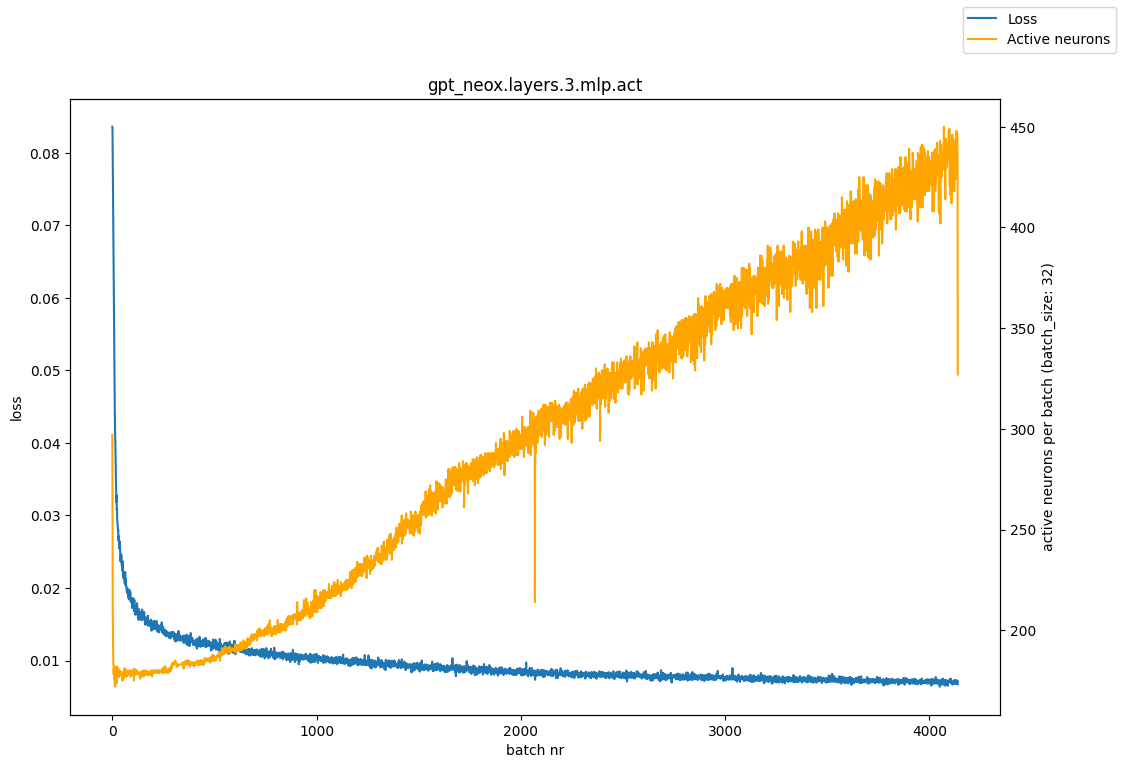

In [9]:
for sae_trainer in sae_trainers:
    hookpoint = sae_trainer.hookpoint
    k = sae_trainer.model.k

    model_out_path = f'{out_folder}/topk{k}/{hookpoint}.pt'
    meta_data_out_path = f'{out_folder}/topk{k}/{hookpoint}.json'
    log_path = f'{log_folder}/topk{k}/{hookpoint}.csv'
    log_fig_path = f'{log_folder}/topk{k}/{hookpoint}.png'


    if not os.path.isdir(f'{out_folder}'):
        os.mkdir(f'{out_folder}')
    if not os.path.isdir(f'{log_folder}'):
        os.mkdir(f'{log_folder}')

    if not os.path.isdir(f'{out_folder}/topk{k}'):
        os.mkdir(f'{out_folder}/topk{k}')
    if not os.path.isdir(f'{log_folder}/topk{k}'):
        os.mkdir(f'{log_folder}/topk{k}')

    torch.save(sae_trainer.model.state_dict(), model_out_path)

    new_meta = {key: value for key, value in meta_data.items()}
    new_meta['batch_size'] = batch_size
    new_meta['num_batches_trained_on'] = sae_trainer.batches
    new_meta['hookpoint'] = sae_trainer.hookpoint
    new_meta['learning_rate'] = learning_rate

    with open(meta_data_out_path, 'w') as file:
        json.dump(new_meta, file, indent=4)

    loss_log, active_neurons_log = zip(*sae_trainer.losses)
    df = pd.DataFrame({
        'loss': loss_log,
        'active_neurons': active_neurons_log
    })
    df.to_csv(log_path)

    sae_trainer.plot_loss(out_file=log_fig_path)

In [9]:
# too big to commit :((((